<a href="https://www.kaggle.com/code/jongryul0519/customer-segmentation-and-rfm-analysis?scriptVersionId=181453776" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
sns.set_style('darkgrid')

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/megastore-sales-data/superstoredata.csv


In [3]:
# loading the dataset
df = pd.read_csv('/kaggle/input/megastore-sales-data/superstoredata.csv')

# looking at top 15 rows
df.head(15)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom,25.50
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom,11.10
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom,11.10
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom,54.08


In [4]:
df.shape

(541909, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
 8   Sales        541909 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 37.2+ MB


In [6]:
# The InvoiceDate looks not a proper data type.
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [7]:
# Let's check how many null values are in the dataset.
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
Sales               0
dtype: int64

In [8]:
# Let's check the overall statistics of the Quantity
df.Quantity.describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

In [9]:
# negative value of Quantity is supposed to returned or cancelled order.
df[df['Quantity']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96
...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,-9.13
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,-224.69
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,-54.75
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,-1.25


In [10]:
# keeping only those transactions that have successfully ordered
df = df[df['Quantity']>=0]
df.shape

(531285, 9)

In [11]:
# Also, remove the number of unverified Customers.
df = df[~df.CustomerID.isnull()]

In [12]:
# putting UK as one country and combine rest countries into one category
df['Country'] = df['Country'].apply(lambda x:'United Kingdom' if x=='United Kingdom' else 'Others')
df.Country.value_counts(normalize=True)

Country
United Kingdom    0.890484
Others            0.109516
Name: proportion, dtype: float64

In [13]:
# checking the data again.
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Sales          0
dtype: int64

In [14]:
# We can see how many kinds of products were on sale.
df.Description.nunique()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


# Visualization

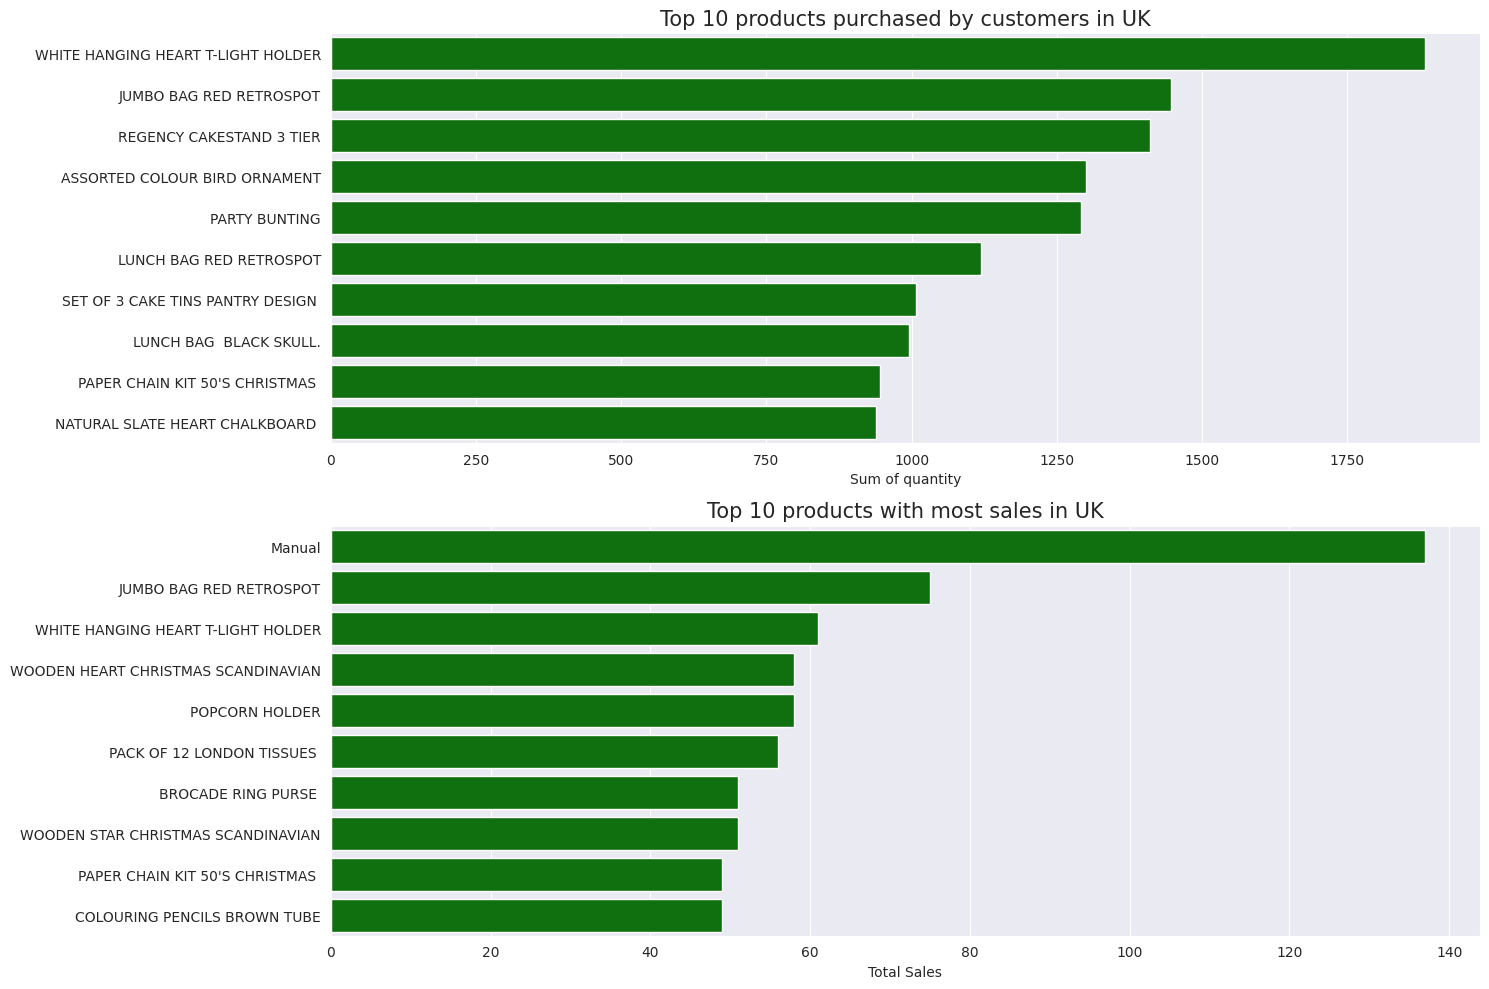

In [15]:
# Let's see the Top 10 products purchased by customers in UK and the most sales in UK
column = ['InvoiceNo','Sales']

plt.figure(figsize=(15,10))
for i,j in enumerate(column):
    plt.subplot(2,1,i+1)
    sns.barplot(x = df[df['Country']=='United Kingdom'].groupby('Description')[j].nunique().sort_values(ascending=False).head(10).values,
                y = df[df['Country']=='United Kingdom'].groupby('Description')[j].nunique().sort_values(ascending=False).head(10).index,
                color='Green')
    plt.ylabel('')
    if i==0:
        plt.xlabel('Sum of quantity')
        plt.title('Top 10 products purchased by customers in UK',size=15)
    else:
        plt.xlabel('Total Sales')
        plt.title('Top 10 products with most sales in UK',size=15)
    
plt.tight_layout()
plt.show()

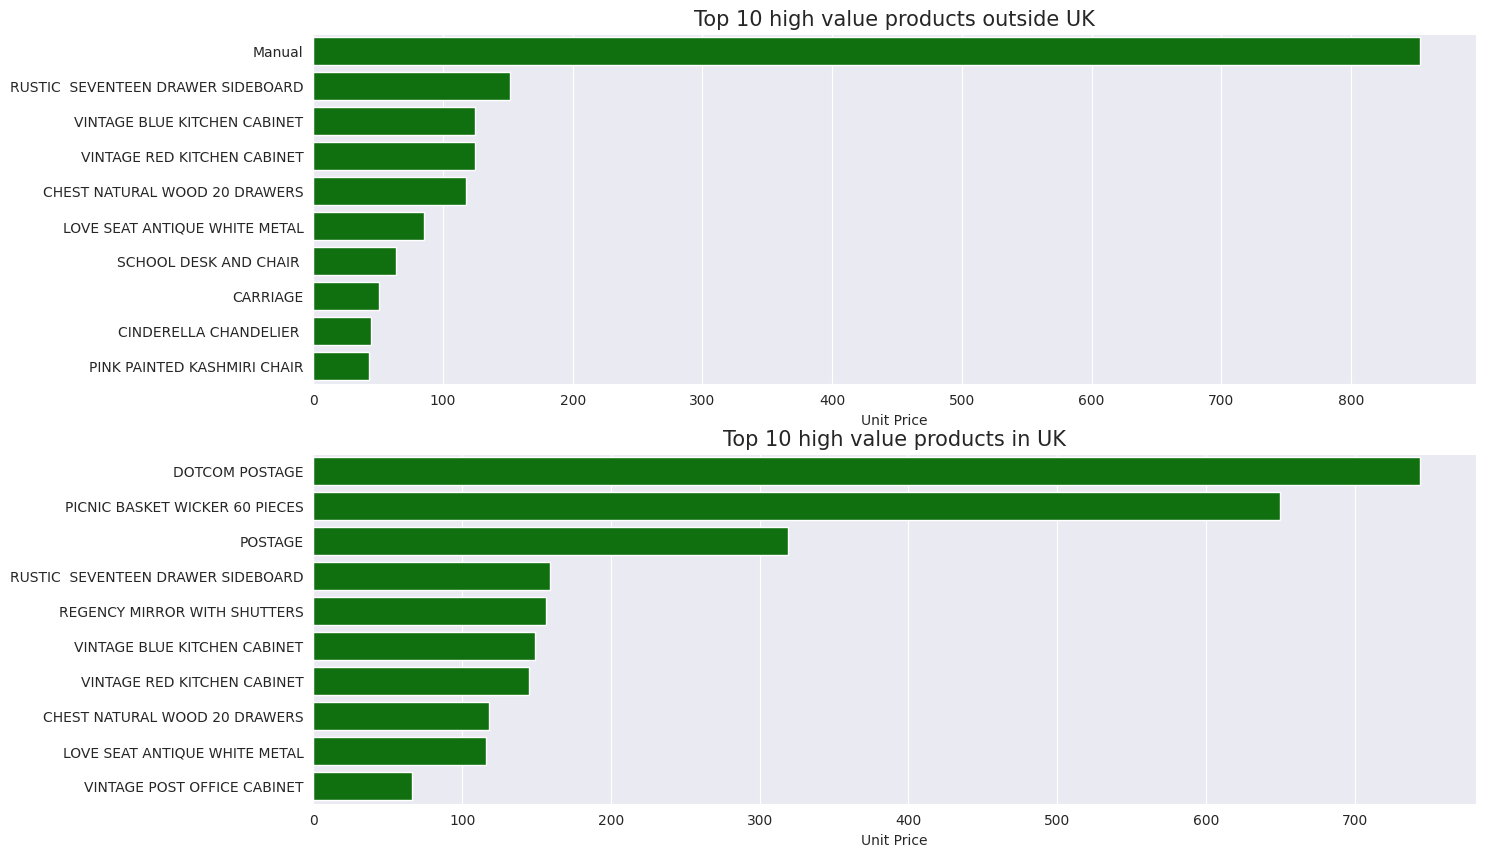

In [16]:
# with the same way, let's see outside of the UK
column = ['Others','United Kingdom']

plt.figure(figsize=(15,10))
for i,j in enumerate(column):
    plt.subplot(2,1,i+1)
    sns.barplot(x = df[df['Country']==j].groupby('Description')['UnitPrice'].mean().sort_values(ascending=False).head(10).values,
                y = df[df['Country']==j].groupby('Description')['UnitPrice'].mean().sort_values(ascending=False).head(10).index,
                color='Green')
    plt.ylabel('')
    if i==0:
        plt.xlabel('Unit Price')
        plt.title('Top 10 high value products outside UK',size=15)
    else:
        plt.xlabel('Unit Price')
        plt.title('Top 10 high value products in UK',size=15)

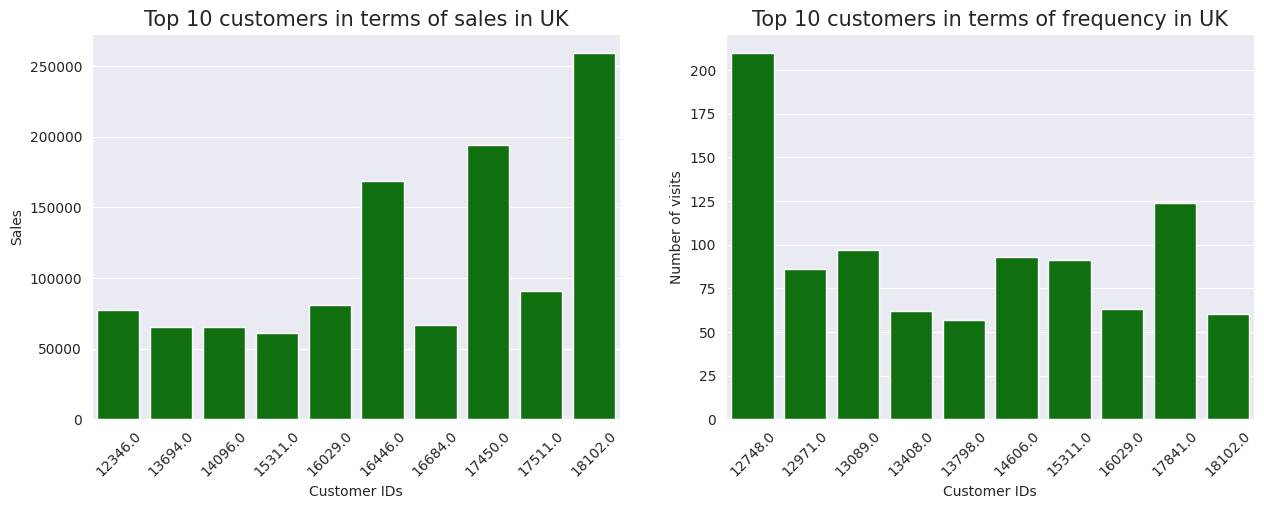

In [17]:
# Let's see who is the most spent customer and bought many items 
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(y = df[df['Country']=='United Kingdom'].groupby('CustomerID')['Sales'].sum().sort_values(ascending=False).head(10).values,
            x = df[df['Country']=='United Kingdom'].groupby('CustomerID')['Sales'].sum().sort_values(ascending=False).head(10).index, 
            color='green')
plt.ylabel('Sales')
plt.xlabel('Customer IDs')
plt.xticks(rotation=45)
plt.title('Top 10 customers in terms of sales in UK',size=15)

plt.subplot(1,2,2)
sns.barplot(y = df[df['Country']=='United Kingdom'].groupby('CustomerID')['InvoiceNo'].nunique().sort_values(ascending=False).head(10).values,
            x = df[df['Country']=='United Kingdom'].groupby('CustomerID')['InvoiceNo'].nunique().sort_values(ascending=False).head(10).index, 
            color='green')
plt.ylabel('Number of visits')
plt.xlabel('Customer IDs')
plt.xticks(rotation=45)
plt.title('Top 10 customers in terms of frequency in UK',size=15)

plt.show()

In [18]:
# To track the time-series trends, break the column by year, month, and day
df['year'] = df['InvoiceDate'].dt.year
df['month'] = df['InvoiceDate'].dt.month
df['day'] = df['InvoiceDate'].dt.day

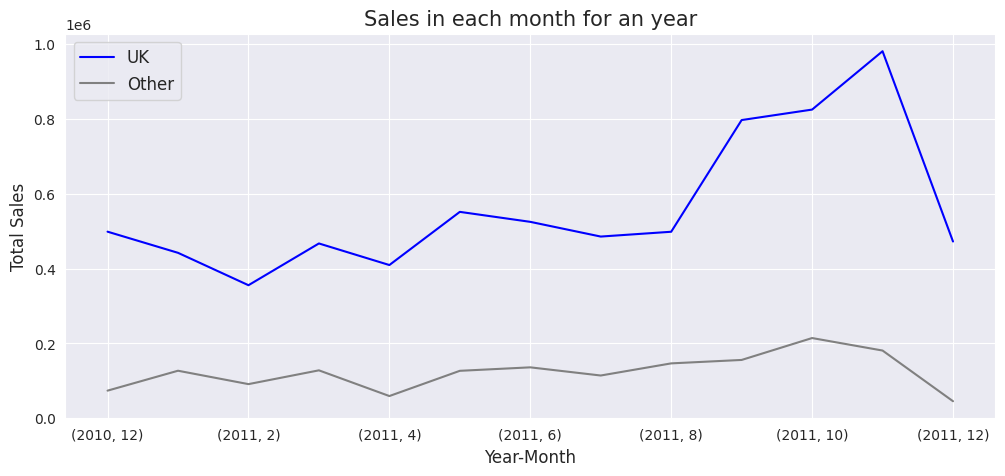

In [19]:
plt.figure(figsize=(12,5))
df[df['Country']=='United Kingdom'].groupby(['year','month'])['Sales'].sum().plot(kind='line',label='UK',color='blue')
df[df['Country']=='Others'].groupby(['year','month'])['Sales'].sum().plot(kind='line',label='Other',color='grey')
plt.xlabel('Year-Month',size=12)
plt.ylabel('Total Sales', size=12)
plt.title('Sales in each month for an year', size=15)
plt.legend(fontsize=12)
plt.show()

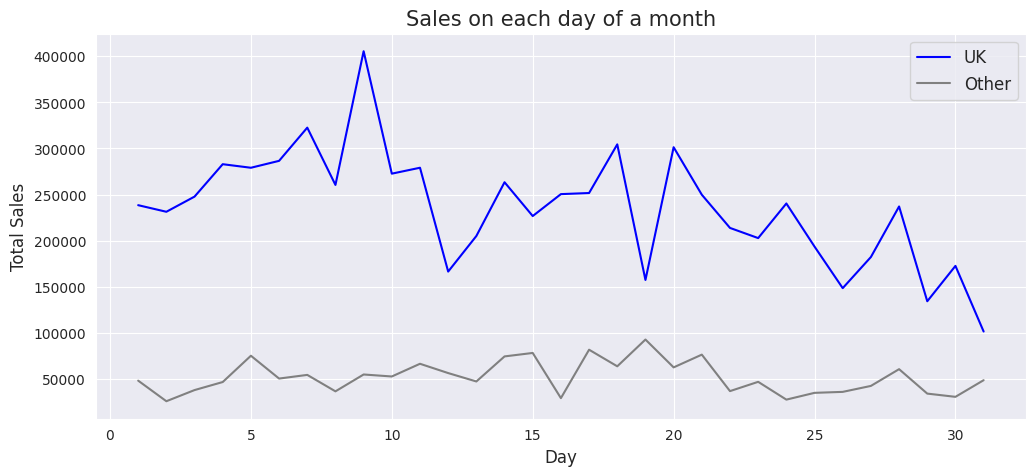

In [20]:
plt.figure(figsize=(12,5))
df[df['Country']=='United Kingdom'].groupby(['day'])['Sales'].sum().plot(kind='line',label='UK',color='blue')
df[df['Country']=='Others'].groupby(['day'])['Sales'].sum().plot(kind='line',label='Other',color='grey')
plt.xlabel('Day',size=12)
plt.ylabel('Total Sales', size=12)
plt.title('Sales on each day of a month', size=15)
plt.legend(fontsize=12)
plt.show()

# RFM Analysis

In [21]:
# Let's populate the dataset for the RFM
today_date = dt.datetime(2011, 12, 11)
rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda InvoiceDate: (today_date - InvoiceDate.max()).days,
                                     'InvoiceNo': lambda InvoiceNo: InvoiceNo.nunique(),
                                     'Sales': lambda Sales: Sales.sum()})

rfm.head()

,InvoiceDate,InvoiceNo,Sales
CustomerID,,,
12346.0,326,1,77183.60
12347.0,3,7,4310.00
12348.0,76,4,1797.24
12349.0,19,1,1757.55
12350.0,311,1,334.40


In [22]:
# Create columns for each of RFM and make score columns of each RFM with the 5 Likert Scale to calculate the total RFM score
rfm.columns = ['recency', 'frequency', 'monetary']

rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])



In [23]:
rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str))

In [24]:
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,5,11
12347.0,3,7,4310.00,5,5,5,55
12348.0,76,4,1797.24,2,4,4,24
12349.0,19,1,1757.55,4,1,4,41
12350.0,311,1,334.40,1,1,2,11


In [25]:
# Specifically assign the name of each segmentation.
seg_map = {
    r'[1-2][1-2]': 'One-time customer',
    r'[1-2][3-4]': 'Occasional customer',
    r'[1-2]5': 'Retarget needed',
    r'3[1-2]': 'Retarget needed',
    r'33': 'Regular Customers',
    r'[3-4][4-5]': 'Loyal customers',
    r'41': 'Almost new customer',
    r'51': 'New customers',
    r'[4-5][2-3]': 'Promising customer',
    r'5[4-5]': 'Mania'
}

In [26]:
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)

rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,5,11,One-time customer
12347.0,3,7,4310.00,5,5,5,55,Mania
12348.0,76,4,1797.24,2,4,4,24,Occasional customer
12349.0,19,1,1757.55,4,1,4,41,Almost new customer
12350.0,311,1,334.40,1,1,2,11,One-time customer


In [27]:
# Let's check the statistics of RFM
rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(["mean", "count"])

recency        frequency           monetary      
                           mean count       mean count         mean count
segment                                                                  
Almost new customer   23.421053    95   1.000000    95   290.913158    95
Loyal customers       33.608059   819   6.479853   819  2864.247791   819
Mania                  6.361769   633  12.417062   633  6857.935482   633
New customers          7.428571    42   1.000000    42   388.212857    42
Occasional customer  153.785835   593   2.878583   593  1084.535297   593
One-time customer    217.605042  1071   1.101774  1071   488.643307  1071
Promising customer    17.398760   484   2.010331   484  1041.222004   484
Regular Customers     52.427807   187   2.326203   187   897.627861   187
Retarget needed       65.404819   415   2.257831   415   824.818892   415

In [28]:
rfm[rfm["segment"] == "One-time customer"].head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
CustomerID,,,,,,,,
12346.0,326,1,77183.6,1,1,5,11,One-time customer
12350.0,311,1,334.4,1,1,2,11,One-time customer
12353.0,205,1,89.0,1,1,1,11,One-time customer
12354.0,233,1,1079.4,1,1,4,11,One-time customer
12355.0,215,1,459.4,1,1,2,11,One-time customer


In [29]:
rfm = rfm[["recency", "frequency", "monetary", "segment"]]

In [30]:
# Now, we can see the final result.
rfm.head(20)

,recency,frequency,monetary,segment
CustomerID,,,,
12346.0,326,1,77183.60,One-time customer
12347.0,3,7,4310.00,Mania
12348.0,76,4,1797.24,Occasional customer
12349.0,19,1,1757.55,Almost new customer
12350.0,311,1,334.40,One-time customer
12352.0,37,8,2506.04,Loyal customers
12353.0,205,1,89.00,One-time customer
12354.0,233,1,1079.40,One-time customer
12355.0,215,1,459.40,One-time customer


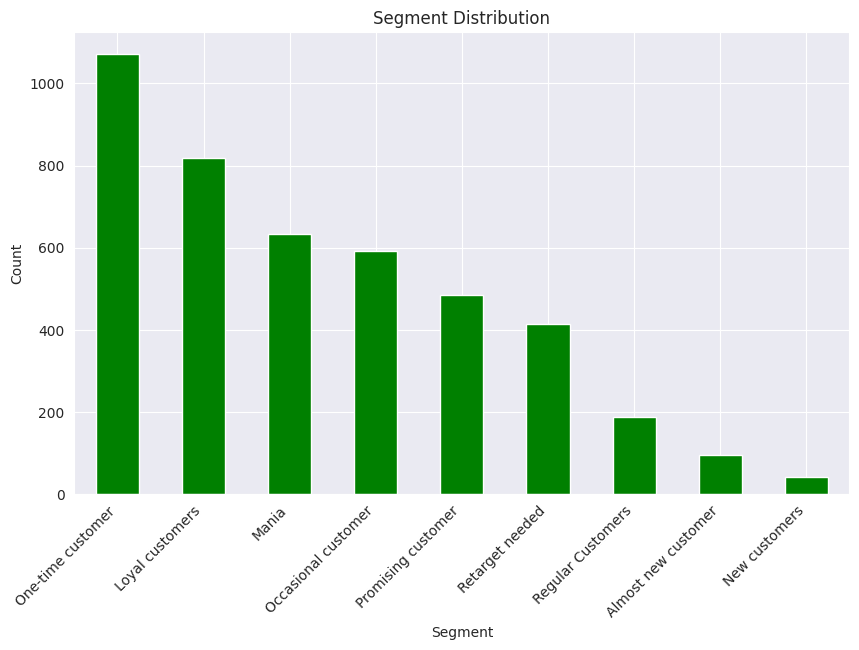

In [31]:
segment_counts = rfm['segment'].value_counts()
segment_counts.plot(kind='bar', figsize=(10, 6), color='green')
plt.title('Segment Distribution')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

In [32]:
segment_percentage = (segment_counts / segment_counts.sum()) * 100
print("Percentage of each segment:")
print(segment_percentage)

Percentage of each segment:
segment
One-time customer      24.683107
Loyal customers        18.875317
Mania                  14.588615
Occasional customer    13.666743
Promising customer     11.154644
Retarget needed         9.564416
Regular Customers       4.309749
Almost new customer     2.189445
New customers           0.967965
Name: count, dtype: float64
